In [320]:
import numpy             as np
import pandas            as pd
import os
import seaborn           as sns
import matplotlib.pyplot as plt

sns.set_theme()

from sklearn.svm             import LinearSVC
from sklearn.ensemble        import RandomForestClassifier, VotingClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.tree            import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics         import accuracy_score

from google.colab import drive, output

drive.mount('/content/drive', force_remount = True)
output.clear()

### Assignment 1: Implement a Multi-omics classifier

Download simulated_dataset.rar from the Teaching Portal. After decompressing the file, you will have: mRNA.txt, meth.txt, prot.txt which contain respectively transcriptome, genome and proteome of a simulated dataset. In clusters.txt you can find the label number for each sample.

Compare early and late integration approaches for sample classification.

• For both approaches implement 4 different classifiers. One of these must output not only the class label but also its probability

• Pay attention in balancing the classes and in the feature selection/dimensionality reduction process.

Which are the differences in early and late integration classifiers in terms of performances? The performances are affected by the type of classifier? Which differences can you notice looking at the probability?

In [332]:
BASE_PATH         = "/content/drive/MyDrive/Datasets/simulated_dataset"

METH_FILENAME     = f"{BASE_PATH}/meth.txt"
CLUSTERS_FILENAME = f"{BASE_PATH}/clusters.txt"
MRNA_FILENAME     = f"{BASE_PATH}/mRNA.txt"
PROTEINS_FILENAME = f"{BASE_PATH}/prot.txt"

#### Early integration classification

Done!


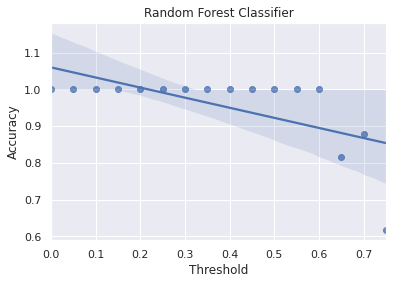

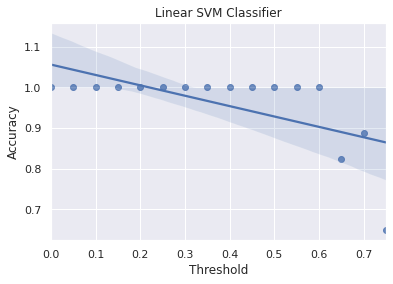

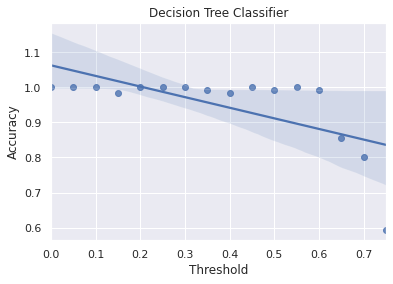

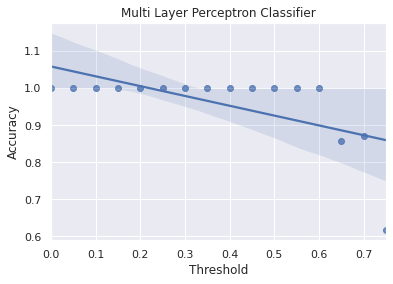

In [337]:
# Early integration
meth_data, cluster_data, mRNA_data, proteins_data = load_data(METH_FILENAME, CLUSTERS_FILENAME, MRNA_FILENAME, PROTEINS_FILENAME)

data = early_integration_data(meth_data, cluster_data, mRNA_data, proteins_data).astype(np.float32)

rfc_accuracies = {}
lsv_accuracies = {}
dtc_accuracies = {}
mlp_accuracies = {}

for i in np.arange(0.0, 0.8, 0.05):
  print(f"Filtering with threshold {i}")
  features_selected = features_selection(data, correlation_threshold = i)
  selected_data     = data[features_selected]

  X = selected_data.drop(["cluster"], axis = 1)
  y = selected_data["cluster"].astype(np.int32)

  X_train, X_test, y_train, y_test = train_test_split(X, y)

  rfc_accuracy = train_model(
      RandomForestClassifier(),
      X_train,
      y_train,
      X_test,
      y_test,
      verbose = False
  )

  lsv_accuracy = train_model(
      LinearSVC(max_iter=300000),
      X_train,
      y_train,
      X_test,
      y_test,
      verbose = False
  )
    
  dtc_accuracy = train_model(
      DecisionTreeClassifier(),
      X_train,
      y_train,
      X_test,
      y_test,
      verbose = False
  )
      
  mlp_accuracy = train_model(
      MLPClassifier(max_iter=30000),
      X_train,
      y_train,
      X_test,
      y_test,
      verbose = False
  )
      
  rfc_accuracies[i] = rfc_accuracy
  lsv_accuracies[i] = lsv_accuracy
  dtc_accuracies[i] = dtc_accuracy
  mlp_accuracies[i] = mlp_accuracy

output.clear()
print("Done!")

rfc = pd.DataFrame(list(rfc_accuracies.items()), columns = ["Threshold", "Accuracy"])
lsv = pd.DataFrame(list(lsv_accuracies.items()), columns = ["Threshold", "Accuracy"])
dtc = pd.DataFrame(list(dtc_accuracies.items()), columns = ["Threshold", "Accuracy"])
mlp = pd.DataFrame(list(mlp_accuracies.items()), columns = ["Threshold", "Accuracy"])

plot_accuracies_clf(rfc, lsv, dtc, mlp)

#### Late integration classification

Done!


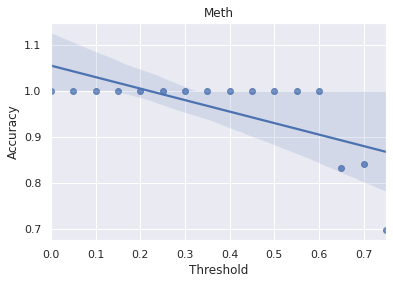

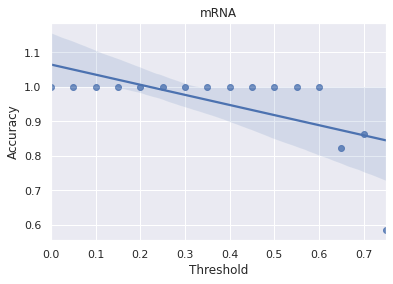

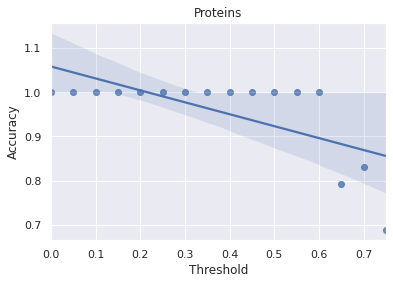

In [338]:
# Late integration
meth_data, cluster_data, mRNA_data, proteins_data = load_data(METH_FILENAME, CLUSTERS_FILENAME, MRNA_FILENAME, PROTEINS_FILENAME)

meth_data, mRNA_data, proteins_data = late_integration_data(meth_data, cluster_data, mRNA_data, proteins_data)

datasets = [(meth_data, "Meth"), (mRNA_data, "mRNA"), (proteins_data, "Proteins")]

for (data, dataset_name) in datasets:

  accuracies = {}

  for i in np.arange(0.0, 0.8, 0.05):
    print(f"Filtering with threshold {i}")
    features_selected = features_selection(data, correlation_threshold = i)
    selected_data     = data[features_selected]

    X = selected_data.drop(["cluster"], axis = 1)
    y = selected_data["cluster"].astype(np.int32)

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    accuracy = train_model(
        VotingClassifier(estimators = [
          ("RFC", RandomForestClassifier()     ),
          ("LSV", LinearSVC(max_iter=300000)   ),
          ("DTC", DecisionTreeClassifier()     ),   
          ("MLP", MLPClassifier(max_iter=30000))
        ]),
        X_train,
        y_train,
        X_test,
        y_test,
        verbose = False
    )
        
    accuracies[i] = accuracy

  if dataset_name == "Meth":
    meth_accuracies     = accuracies

  if dataset_name == "mRNA":
    mRNA_accuracies     = accuracies
  
  if dataset_name == "Proteins":
    proteins_accuracies = accuracies

  output.clear()

print("Done!")

meth     = pd.DataFrame(list(meth_accuracies.items()),     columns = ["Threshold", "Accuracy"])
mRNA     = pd.DataFrame(list(mRNA_accuracies.items()),     columns = ["Threshold", "Accuracy"])
proteins = pd.DataFrame(list(proteins_accuracies.items()), columns = ["Threshold", "Accuracy"])

plot_accuracies_ds(meth, mRNA, proteins)

#### Code

In [336]:
def load_data(METH_FILENAME, CLUSTERS_FILENAME, MRNA_FILENAME, PROTEINS_FILENAME):
  meth_data     = pd.read_csv(METH_FILENAME,     sep="\t").T
  cluster_data  = pd.read_csv(CLUSTERS_FILENAME, sep="\t")
  mRNA_data     = pd.read_csv(MRNA_FILENAME,     sep="\t").T
  proteins_data = pd.read_csv(PROTEINS_FILENAME, sep="\t").T

  meth_data     = remodel_dataset(meth_data)
  cluster_data  = remodel_dataset(cluster_data, is_cluster = True)
  mRNA_data     = remodel_dataset(mRNA_data)
  proteins_data = remodel_dataset(proteins_data)
  
  return meth_data, cluster_data, mRNA_data, proteins_data

def remodel_dataset(df, is_cluster = False):

  if is_cluster == True:

    indexes = df["subjects"]
    new_df  = pd.DataFrame(df["cluster.id"].values, index=indexes, columns = ["cluster"])

  else:

    headers = df.iloc[0]
    headers.name = "subjects"

    indexes = df.index[1:]
    new_df  = pd.DataFrame(df.values[1:], columns=headers, index=indexes)

  return new_df

def early_integration_data(meth_data, cluster_data, mRNA_data, proteins_data):
  
  data = meth_data
  data = data.merge(cluster_data,  left_index = True, right_index = True)
  data = data.merge(mRNA_data,     left_index = True, right_index = True)
  data = data.merge(proteins_data, left_index = True, right_index = True)
  
  return data

def late_integration_data(meth_data, cluster_data, mRNA_data, proteins_data):
  return (
    meth_data    .merge(cluster_data, left_index = True, right_index = True).astype(np.float32),
    mRNA_data    .merge(cluster_data, left_index = True, right_index = True).astype(np.float32),
    proteins_data.merge(cluster_data, left_index = True, right_index = True).astype(np.float32)
  )

# Feature selection using Pearson
def features_selection(data, correlation_threshold):
  
  cor = data.corr()
  cor_target = abs(cor["cluster"])
  relevant_features = cor_target[cor_target>correlation_threshold].index.tolist()
  
  return relevant_features

def train_model(model, X_train, y_train, X_test, y_test, verbose = True):
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)

  accuracy = accuracy_score(y_test, predictions)

  if verbose == True:
    print(f"Accuracy: {accuracy}")

  return accuracy

def plot_accuracies_clf(rfc, lsv, dtc, mlp):
  sns.regplot(
      data=rfc, 
      x="Threshold", y="Accuracy", 
  ).set_title("Random Forest Classifier")
  plt.show()

  sns.regplot(
      data=lsv, 
      x="Threshold", y="Accuracy", 
  ).set_title("Linear SVM Classifier")
  plt.show()

  sns.regplot(
      data=dtc, 
      x="Threshold", y="Accuracy", 
  ).set_title("Decision Tree Classifier")
  plt.show()

  sns.regplot(
      data=mlp, 
      x="Threshold", y="Accuracy", 
  ).set_title("Multi Layer Perceptron Classifier")
  plt.show()

def plot_accuracies_ds(meth, mRNA, proteins):
  sns.regplot(
      data=meth, 
      x="Threshold", y="Accuracy", 
  ).set_title("Meth")
  plt.show()

  sns.regplot(
      data=mRNA, 
      x="Threshold", y="Accuracy", 
  ).set_title("mRNA")
  plt.show()

  sns.regplot(
      data=proteins, 
      x="Threshold", y="Accuracy", 
  ).set_title("Proteins")
  plt.show()